<a href="https://colab.research.google.com/github/natalrhyme/eCommerce-Transactions-dataset/blob/main/Rishabh_sangwan_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-8-bfaeb53742cb>:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Optimal number of clusters: 5
Davies-Bouldin Index: 0.8524813520458038
Silhouette Score: 0.3535127066812944


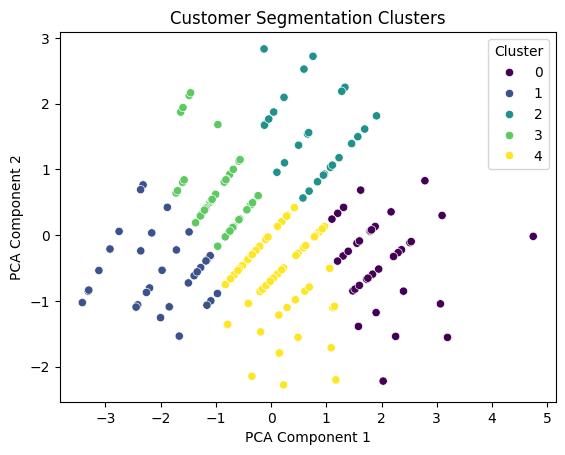

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

transactions = transactions.merge(products, on='ProductID', how='left')
df = transactions.merge(customers, on='CustomerID', how='left')

# Feature Engineering
customer_features = df.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean'],
    'TransactionID': 'count'
})
customer_features.columns = ['Total_Spend', 'Avg_Spend', 'Transaction_Count']

# Encode categorical data
encoder = OneHotEncoder()
region_encoded = encoder.fit_transform(customers[['Region']]).toarray()
region_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['Region']))

data = customer_features.join(region_df)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

data_scaled = np.nan_to_num(data_scaled)

# Determine optimal number of clusters using DB Index
best_k = 2
best_db_index = float('inf')
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(data_scaled)
    db_index = davies_bouldin_score(data_scaled, clusters)
    if db_index < best_db_index:
        best_k = k
        best_db_index = db_index

print(f'Optimal number of clusters: {best_k}')

kmeans = KMeans(n_clusters=best_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(data_scaled)

db_index = davies_bouldin_score(data_scaled, data['Cluster'])
silhouette_avg = silhouette_score(data_scaled, data['Cluster'])

print(f'Davies-Bouldin Index: {db_index}')
print(f'Silhouette Score: {silhouette_avg}')

# Visualization using PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1], hue=data['Cluster'], palette='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segmentation Clusters')
plt.show()
